# Algorithmic Trading Model for Mean-Reversion vs. Trend-Following Strategy for an Individual Stock Using Python
### David Lowe
### July 14, 2021

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This algorithmic trading model compares a simple mean-reversion strategy with a trend-following for a single stock. The model will use a trend window size of ten days for long trades only.

ANALYSIS: In this modeling iteration, we analyzed the stock prices for Costco Wholesale (COST) between January 1, 2016, and July 9, 2021. The mean-reversion model produced a profit of 101.20 dollars per share, while the trend-following model returned a profit of 154.21. The buy-and-hold approach yielded a gain of 248.74 dollars per share.

CONCLUSION: For the COST stock during the modeling time frame, the long-only trading strategy with either mean-reversion or trend-following approach did not produce a better return than the buy-and-hold approach. We should consider modeling this stock further by experimenting with more variations of the strategy.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Quandl

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Implement and Train Models
4. Back-test Models
5. Evaluate Strategy Performance

## Task 1 - Prepare Environment

### 1.a) Load libraries and modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from datetime import date, datetime, timedelta
import requests
import json
from dotenv import load_dotenv

# Begin the timer for the script processing
startTimeScript = datetime.now()

### 1.b) Set up the controlling parameters and functions¶

In [2]:
# Specify the key modeling parameters below
INITIAL_CAPITAL = 0

# Specify the moving average parameters for the trading strategy
TREND_WINDOW = 10
VOLUME_WINDOW = 10
HOLDING_PERIOD_MIN = 999
HOLDING_PERIOD_MAX = 999
GAIN_MAX = 0.99
LOSS_MAX = 0.99

LONG_ONLY = True
SHORT_ONLY = False
if LONG_ONLY and SHORT_ONLY: sys.exit("Cannot have both LONG_ONLY and SHORT_LONG flags be set to True. Script Processing Aborted!!!")

# The number of extra days of data we need for calculating moving averages (usually equals to the largest value of window size)
EXTRA_DAYS = TREND_WINDOW

MODEL_START_DATE = date(2016, 1, 1)
print("Starting date for the model:", MODEL_START_DATE)

# MODEL_END_DATE = datetime.now().date()
MODEL_END_DATE = date(2021, 7, 9)
print("Ending date for the model:", MODEL_END_DATE)

# data_start_date = MODEL_START_DATE
data_start_date = MODEL_START_DATE - timedelta(days=int(EXTRA_DAYS * 2)) # Need more pricing data to calculate moving averages
print("First date of data we need for modeling:", data_start_date)

data_end_date = MODEL_END_DATE
print("Last date of data we need for modeling:", data_end_date)

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose_signals = False
verbose_trade_actions = False
verbose_portfolios = False
verbose_transactions = False
verbose_entry_exit = True

Starting date for the model: 2016-01-01
Ending date for the model: 2021-07-09
First date of data we need for modeling: 2015-12-12
Last date of data we need for modeling: 2021-07-09


## Task 2 - Acquire and Pre-Process Data

In [3]:
def retrieve_stock_data(ticker=''):
    # Set up the data service provider and data acquisition parameters
    data_service = 'Quandl'

    # Check and see whether the API key is available
    api_key = os.environ.get('QUANDL_API')
    if api_key is None: sys.exit(data_service + ' API key not available. Script processing cannot continue!!!')

    if ticker=='': sys.exit('Stock symbol not available. Script processing cannot continue!!!')

    start_date_string = data_start_date.strftime('%Y-%m-%d')
    end_date_string = data_end_date.strftime('%Y-%m-%d')
    api_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s&qopts.data_version=2" % (start_date_string, end_date_string, ticker, api_key)
    response = requests.get(api_url)
    resp_dict = json.loads(response.text)
    stock_rawdata = pd.DataFrame(resp_dict['datatable']['data'])
    print(len(stock_rawdata), 'data points retrieved from the API call.')

    stock_rawdata.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'closeadj', 'closeunadj', 'lastupdated']
    # stock_rawdata.set_index('date', inplace=True)
    stock_rawdata.index = pd.to_datetime(stock_rawdata.date)
    stock_pricing = stock_rawdata.sort_index(ascending=True)
    print(stock_pricing.head())
    print()
    print(stock_pricing.tail())

    # Set up the standard column name for modeling
    # Column names may be data-provider specific!
    model_template = stock_pricing.loc[:, ['open','closeadj','volume']]
    model_template.rename(columns={'open': 'open_price', 'closeadj': 'close_price', 'volume': 'trading_volume'}, inplace=True)
    print(model_template.head())
    print()
    print(model_template.tail())

    return model_template

## Task 3 - Implement and Train Models

In [4]:
# Define the function that will generate the indicators and trading signals
# General logic for processing the trading signals for each time period
# 1 - Check to see whether we need to execute a trading action from the previous day's signal. Once the trading action is executed, move on to the next day.
# 2 - If no trade actions to execute on open, check to see whether we have any breakout that generates a trading signal. If we have a new trading signal and currently has no position, mark the entry action for the next day.
# 3 - If no new signal for today, check to see whether we need to exit any existing position. If we have an exit signal and currently hold a position, mark the exit action for the next day.
# 4 - If nothing is going on, mark up the trading model appropriately and move to the next day.

def populate_signals_mr_tf(model_template, mean_reversion=True, trend_window=TREND_WINDOW, volume_window=VOLUME_WINDOW):

    trade_model = model_template.copy()
    trade_model['buy_on_open'] = False
    trade_model['sell_on_open'] = False
    trade_model['short_on_open'] = False
    trade_model['cover_on_open'] = False
    trade_model['holding_period'] = None
    trade_model['cost_basis'] = None
    trade_model['pandl_pct'] = None
    trade_model['position_long'] = None
    trade_model['position_short'] = None
    trade_model['window_avg'] = trade_model['close_price'].shift(1).rolling(window=trend_window).mean()
    trade_model['window_high'] = trade_model['close_price'].shift(1).rolling(window=trend_window).max()
    trade_model['window_low'] = trade_model['close_price'].shift(1).rolling(window=trend_window).min()
    trade_model['volume_ma'] = trade_model['trading_volume'].rolling(volume_window).mean()

    # Truncate the model to the required starting and ending dates
    trade_model = trade_model[MODEL_START_DATE:MODEL_END_DATE]
    last_index = len(trade_model) - 1

    for k in range(len(trade_model)):
        # Calculate the magnitude of breakout. Positive value means breaking out towards a direction
        price_today = trade_model.at[trade_model.index[k],'close_price']
        price_high =  trade_model.at[trade_model.index[k],'window_high']
        price_low = trade_model.at[trade_model.index[k],'window_low']
        price_avg = trade_model.at[trade_model.index[k],'window_avg']
        if mean_reversion:
            breakout_long_side = price_today < price_low
            breakout_short_side = price_today > price_high
        else:
            breakout_long_side = price_today > price_high
            breakout_short_side = price_today < price_low
        volume_today = trade_model.at[trade_model.index[k],'trading_volume']
        volume_avg = trade_model.at[trade_model.index[k],'volume_ma']
        close_above_avg = price_today > price_avg
        close_below_avg = price_today < price_avg
        if k == 0:
            currently_long = False
            currently_short = False
            holding_period = 0
            cost_basis = 0
        else:
            currently_long = trade_model.at[trade_model.index[k-1],'position_long']
            currently_short = trade_model.at[trade_model.index[k-1],'position_short']
            holding_period = trade_model.at[trade_model.index[k-1],'holding_period']
            cost_basis = trade_model.at[trade_model.index[k-1],'cost_basis']

        trade_executed_today = False

        # Check to see whether we need to execute any trade action on open
        if trade_model.at[trade_model.index[k],'buy_on_open']:
            trade_executed_today = True
            currently_long = True
            currently_short = False
            holding_period = 1
            cost_basis = -trade_model.at[trade_model.index[k],'open_price']
        elif trade_model.at[trade_model.index[k],'short_on_open']:
            trade_executed_today = True
            currently_long = False
            currently_short = True
            holding_period = 1
            cost_basis = trade_model.at[trade_model.index[k],'open_price']
        elif trade_model.at[trade_model.index[k],'sell_on_open']:
            trade_executed_today = True
            currently_long = False
            currently_short = False
            holding_period = 0
            cost_basis = 0.0
        elif trade_model.at[trade_model.index[k],'cover_on_open']:
            trade_executed_today = True
            currently_long = False
            currently_short = False
            holding_period = 0
            cost_basis = 0.0
        else:
            # If no trade on open, check to see whether we have a breakout with an entry the next day
            if breakout_long_side and (not currently_long) and (not currently_short) and (volume_today > volume_avg) and (k < last_index-1) and (not SHORT_ONLY):
                trade_model.at[trade_model.index[k+1],'buy_on_open'] = True
            elif breakout_short_side and (not currently_long) and (not currently_short) and (volume_today > volume_avg) and (k < last_index-1) and (not LONG_ONLY):
                trade_model.at[trade_model.index[k+1],'short_on_open'] = True
            else:
                # If no breakout, check to see whether we need to exit an existing position the next day
                if currently_short and (k < last_index-1):
                    if (mean_reversion and close_below_avg) or ((not mean_reversion) and close_above_avg) or (holding_period+1 >= HOLDING_PERIOD_MAX):
                        trade_model.at[trade_model.index[k+1],'cover_on_open'] = True
                elif currently_long and (k < last_index-1):
                    if (mean_reversion and close_above_avg) or ((not mean_reversion) and close_below_avg) or (holding_period+1 >= HOLDING_PERIOD_MAX):
                        trade_model.at[trade_model.index[k+1],'sell_on_open'] = True

        # If no action on a given day, carry over the position status
        if (k > 0) and (not trade_executed_today):
            if currently_long or currently_short:
                holding_period = holding_period + 1

        trade_model.at[trade_model.index[k],'position_long'] = currently_long
        trade_model.at[trade_model.index[k],'position_short'] = currently_short
        trade_model.at[trade_model.index[k],'holding_period'] = holding_period
        trade_model.at[trade_model.index[k],'cost_basis'] = cost_basis

        # Check to see whether the profit or loss target has been met for exiting the position
        if currently_long :
            pandl_pct = (cost_basis + price_today) / abs(cost_basis)
            trade_model.at[trade_model.index[k],'pandl_pct'] = pandl_pct
            if (pandl_pct >= GAIN_MAX) or (pandl_pct <= -LOSS_MAX) :
                trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
        elif currently_short :
            pandl_pct = (cost_basis - price_today) / abs(cost_basis)
            trade_model.at[trade_model.index[k],'pandl_pct'] = pandl_pct
            if (pandl_pct >= GAIN_MAX) or (pandl_pct <= -LOSS_MAX) :
                trade_model.at[trade_model.index[k+1],'cover_on_open'] = True
        else:
            trade_model.at[trade_model.index[k],'pandl_pct'] = 0.0

        # # Exiting the position on the last day of modeling period
        # if k == last_index-1:
        #     if trade_model.at[trade_model.index[k],'position_long']:
        #         trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
        #         trade_model.at[trade_model.index[k+1],'position_long'] = False
        #     elif trade_model.at[trade_model.index[k],'position_short']:
        #         trade_model.at[trade_model.index[k+1],'cover_on_open'] = True
        #         trade_model.at[trade_model.index[k+1],'position_short'] = False

    if verbose_signals: print(trade_model, '\n')
    return trade_model

In [5]:
# List the entry/exit points for each model
def list_model_entry_exit(trade_model):
    print(trade_model[trade_model['buy_on_open'] | trade_model['sell_on_open'] | trade_model['short_on_open'] | trade_model['cover_on_open']])

In [6]:
def draw_model_graph(trade_model, ticker='', model_name=''):
    graph_data = trade_model.copy()
    title_string = model_name + ' Trading Model for ' + ticker
    fig = plt.figure(figsize=(16,9))
    ylabel = ticker + ' price in $'
    ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
    graph_data['close_price'].plot(ax=ax1, color='g')
    graph_data['window_high'].plot(ax=ax1, color='b')
    graph_data['window_low'].plot(ax=ax1, color='r')
    ax1.plot(graph_data.loc[graph_data['buy_on_open']].index, graph_data.close_price[graph_data['buy_on_open']], '^', markersize=7, color='b',label='Buy on Open')
    ax1.plot(graph_data.loc[graph_data['sell_on_open']].index, graph_data.close_price[graph_data['sell_on_open']], 'v', markersize=7, color='b',label='Sell on Open')
    ax1.plot(graph_data.loc[graph_data['short_on_open']].index, graph_data.close_price[graph_data['short_on_open']], '^', markersize=7, color='r',label='Short on Open')
    ax1.plot(graph_data.loc[graph_data['cover_on_open']].index, graph_data.close_price[graph_data['cover_on_open']], 'v', markersize=7, color='r',label='Cover on Open')
    plt.legend(loc='upper left')
    plt.show()

## Task 4 - Back-test Models

In [7]:
def generate_trading_portfolios(trade_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trade_model.index, columns=['trade_action', 'price_executed', 'qty_transacted', 'cost_basis', 'gain_loss', 'qty_on_hand', 'cash_on_hand', 'position_value', 'total_position', 'accum_return'])
    portfolio['trade_action'] = False
    portfolio.at[portfolio.index[0],'price_executed'] = 0.00
    portfolio.at[portfolio.index[0],'qty_transacted'] = 0
    portfolio.at[portfolio.index[0],'cost_basis'] = 0.00
    portfolio.at[portfolio.index[0],'gain_loss'] = 0.00
    portfolio.at[portfolio.index[0],'qty_on_hand'] = 0
    portfolio.at[portfolio.index[0],'cash_on_hand'] = INITIAL_CAPITAL
    portfolio.at[portfolio.index[0],'position_value'] = 0.00
    portfolio.at[portfolio.index[0],'total_position'] = INITIAL_CAPITAL
    portfolio.at[portfolio.index[0],'accum_return'] = 0.00
    quantity = 1

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        price_per_share = trade_model.at[trade_model.index[i],'open_price']
        if trade_model.at[trade_model.index[i],'buy_on_open']:
            # Code block for Buy on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = quantity
            recent_cost = price_per_share * -quantity
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = 0.00
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] + quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + recent_cost
            if verbose_trade_actions: print('BOUGHT QTY:', quantity, 'on', portfolio.index[i].date(), 'at the price of', price_per_share)
        elif trade_model.at[trade_model.index[i],'sell_on_open']:
            # Code block for Sell on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = -quantity
            recent_cost = 0.00
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = (price_per_share * quantity) + portfolio.iloc[i-1]['cost_basis']
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] - quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + (price_per_share * quantity)
            if verbose_trade_actions: print('SOLD QTY:', quantity, 'on', portfolio.index[i].date(), 'at the price of', price_per_share)
        elif trade_model.at[trade_model.index[i],'short_on_open']:
            # Code block for Short on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = -quantity
            recent_cost = price_per_share * quantity
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = 0.00
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] - quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + recent_cost
            if verbose_trade_actions: print('SHORTED QTY:', -quantity, 'on', portfolio.index[i].date(), 'at the price of', trade_model.at[portfolio.index[i],'open_price'])
        elif trade_model.at[trade_model.index[i],'cover_on_open']:
            # Code block for Cover on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = quantity
            recent_cost = 0.00
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = portfolio.iloc[i-1]['cost_basis'] - (price_per_share * quantity)
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] + quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] - (price_per_share * quantity)
            if verbose_trade_actions: print('COVERED QTY:', quantity, 'on', portfolio.index[i].date(), 'at the price of', trade_model.at[portfolio.index[i],'open_price'])
        else:
            # Code block for no trade actions
            portfolio.at[portfolio.index[i],'price_executed'] = 0.00
            portfolio.at[portfolio.index[i],'qty_transacted'] = 0
            portfolio.at[portfolio.index[i],'cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.at[portfolio.index[i],'gain_loss'] = 0.00
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand']
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand']
        portfolio.at[portfolio.index[i],'position_value'] = trade_model.at[trade_model.index[i],'close_price'] * portfolio.at[portfolio.index[i],'qty_on_hand']
        portfolio.at[portfolio.index[i],'total_position'] = portfolio.at[portfolio.index[i],'cash_on_hand'] + portfolio.at[portfolio.index[i],'position_value']
        portfolio.at[portfolio.index[i],'accum_return'] = portfolio.at[portfolio.index[i],'total_position'] - INITIAL_CAPITAL

    if verbose_portfolios: print('\n', portfolio, '\n')
    return portfolio

In [8]:
def calculate_positions_performance(trade_model):
    trade_positions = generate_trading_portfolios(trade_model)
    trade_transactions = trade_positions[trade_positions['trade_action']]
    if verbose_transactions: print(trade_transactions)
    if trade_transactions.at[trade_transactions.index[-1],'trade_action']:
        if trade_transactions.at[trade_transactions.index[-1],'qty_on_hand'] == 0:
            print('The current status of the model is:','Waiting to enter a position since',trade_transactions.index.tolist()[-1].date(),'\n')
        elif trade_transactions.at[trade_transactions.index[-1],'qty_on_hand'] > 0:
            print('The current status of the model is:','Holding a long position since',trade_transactions.index.tolist()[-1].date(),'\n')
        else:
            print('The current status of the model is:','Holding a short position since',trade_transactions.index.tolist()[-1].date(),'\n')
    return trade_positions

## Task 5 - Evaluate Strategy Performance

In [9]:
stock_symbol = 'COST'
stock_model_template = retrieve_stock_data(stock_symbol)
print('Generating the trading signals for the strategy...')
mean_reversion_model = populate_signals_mr_tf(stock_model_template, mean_reversion=True)
if verbose_entry_exit:
    print('List the entry and exit points for the strategy...')
    list_model_entry_exit(mean_reversion_model)
print('Calculating the positions for the strategy...')
mean_reversion_positions = calculate_positions_performance(mean_reversion_model)

1402 data points retrieved from the API call.
           ticker        date    open     high     low   close     volume  \
date                                                                        
2015-12-14   COST  2015-12-14  160.09  161.880  159.41  161.84  2434039.0   
2015-12-15   COST  2015-12-15  163.32  163.740  160.72  161.29  2378746.0   
2015-12-16   COST  2015-12-16  161.95  163.253  160.00  162.76  2196261.0   
2015-12-17   COST  2015-12-17  162.44  163.580  160.60  160.68  1704232.0   
2015-12-18   COST  2015-12-18  159.79  160.680  157.60  157.70  4295780.0   

            closeadj  closeunadj lastupdated  
date                                          
2015-12-14   143.406      161.84  2021-04-29  
2015-12-15   142.918      161.29  2021-04-29  
2015-12-16   144.221      162.76  2021-04-29  
2015-12-17   142.378      160.68  2021-04-29  
2015-12-18   139.737      157.70  2021-04-29  

           ticker        date    open     high      low   close     volume  \
date  

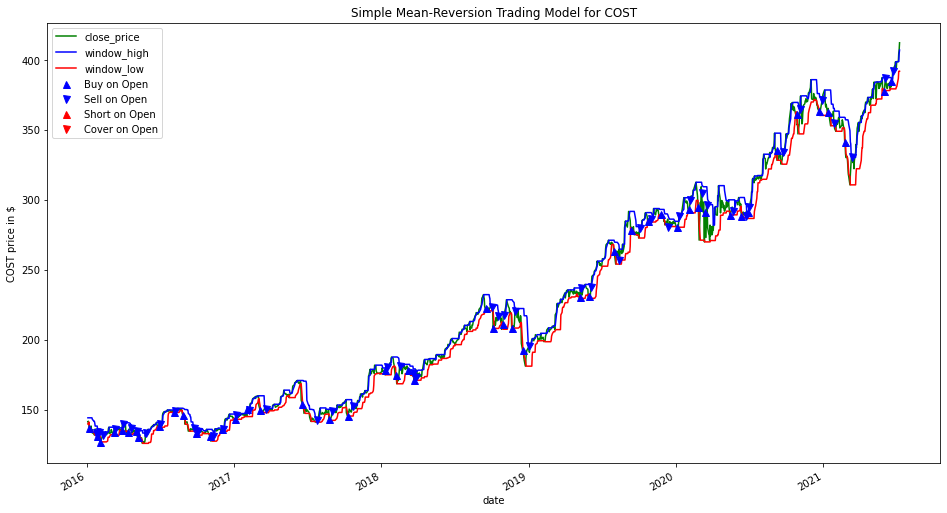

In [10]:
draw_model_graph(mean_reversion_model, stock_symbol, 'Simple Mean-Reversion')

In [11]:
print('Generating the trading signals for the strategy...')
trend_following_model = populate_signals_mr_tf(stock_model_template, mean_reversion=False)
if verbose_entry_exit:
    print('List the entry and exit points for the strategy...')
    list_model_entry_exit(trend_following_model)
print('Calculating the positions for the strategy...')
trend_following_positions = calculate_positions_performance(trend_following_model)

Generating the trading signals for the strategy...
List the entry and exit points for the strategy...
            open_price  close_price  trading_volume  buy_on_open  \
date                                                               
2016-02-25      154.69      137.467       1746889.0         True   
2016-02-29      149.99      133.300       3123546.0        False   
2016-03-31      157.96      140.008       2692398.0         True   
2016-04-08      152.98      134.740       2008484.0        False   
2016-05-27      150.24      132.849       3349772.0         True   
...                ...          ...             ...          ...   
2021-04-30      372.91      372.090       2118990.0         True   
2021-05-13      373.09      379.530       2023855.0        False   
2021-05-28      384.15      378.270       4682400.0         True   
2021-06-02      378.38      380.590       1863357.0        False   
2021-06-23      393.00      391.970       1538035.0         True   

            s

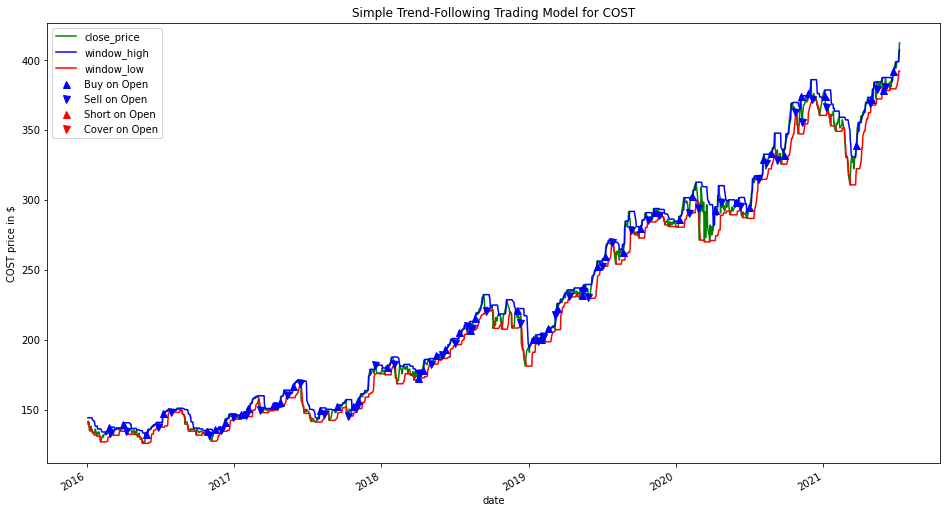

In [12]:
draw_model_graph(trend_following_model, stock_symbol, 'Simple Trend-Following')

In [13]:
# Initialize a dataframe for storing the model's profit and loss
model_performance_summary = pd.DataFrame(columns=['Model_name','Return_value','Return_percentage'])

print('Processing the transactions for the mean-reversion model...')
print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, mean_reversion_positions.accum_return[-1]))
if INITIAL_CAPITAL != 0:
    return_percentage = mean_reversion_positions.accum_return[-1] / INITIAL_CAPITAL * 100
    print('Accumulated return percentage based on the initial capital investment: %.2f%%' % return_percentage)
else:
    return_percentage = None
model_performance_summary = model_performance_summary.append({'Model_name': 'Mean-Reversion', 'Return_value': mean_reversion_positions.accum_return[-1], 'Return_percentage': return_percentage}, ignore_index=True)

print('Processing the transactions for the trend-following model...')
print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, trend_following_positions.accum_return[-1]))
if INITIAL_CAPITAL != 0:
    return_percentage = trend_following_positions.accum_return[-1] / INITIAL_CAPITAL * 100
    print('Accumulated return percentage based on the initial capital investment: %.2f%%' % return_percentage)
else:
    return_percentage = None
model_performance_summary = model_performance_summary.append({'Model_name': 'Trend-Following', 'Return_value': trend_following_positions.accum_return[-1], 'Return_percentage': return_percentage}, ignore_index=True)

Processing the transactions for the mean-reversion model...
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $101.20
Processing the transactions for the trend-following model...
Accumulated profit/loss for one share of stock with initial capital of $0 at the end of modeling period: $154.21


In [14]:
# Calculate the stock's performance for a buy-and-hold model
buy_hold_model = stock_model_template[MODEL_START_DATE:MODEL_END_DATE]
print('The entry point for the buy-and-hold model: $%.2f on %s' % (buy_hold_model.iloc[0]['open_price'], buy_hold_model.index[0].date()))
print('The exit point for the buy-and-hold model: $%.2f on %s' % (buy_hold_model.iloc[-1]['open_price'], buy_hold_model.index[-1].date()))
print('The performance of the buy-and-hold model: $%.2f' %(buy_hold_model.iloc[-1]['open_price'] - buy_hold_model.iloc[0]['open_price']))

The entry point for the buy-and-hold model: $159.81 on 2016-01-04
The exit point for the buy-and-hold model: $408.55 on 2021-07-09
The performance of the buy-and-hold model: $248.74


In [15]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:12.638760
